In [1]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import shap
from modules.utils import constants as c
from modules.utils.common import load_csv, load_scaler, load_parquet
from modules.utils.train_utils import build_global_autoencoder
import seaborn as sns
from tqdm import tqdm
import cv2
import tensorflow as tf
from openai import OpenAI
from flask import json
import os
import math
from IPython.display import display, Markdown


desc_columns = [
    "Number of Black Pixels",
    "Gray Level Threshold",
    "Entropy of Gray Values",
    "Number of Interior Contours",
    "Mean area of Interior Contours",
    "Number of Exterior Curves",
    "Number of Ultra-Fine Strokes",
    "Number of Very Fine Strokes",
    "Number of Fine Strokes",
    "Number of Medium Strokes",
    "Number of Bold Strokes",
    "Number of Heavy Strokes",
    "Mean Gap Between Words",
    "Standard Deviation of Gap Between Words",
    "Number of Words",
    "Chaincode Histogram Right",
    "Chaincode Histogram Down-Right",
    "Chaincode Histogram Down",
    "Chaincode Histogram Down-Left",
    "Chaincode Histogram Left",
    "Chaincode Histogram Up-Left",
    "Chaincode Histogram Up",
    "Chaincode Histogram Up-Right",
    "Contour-Hinge Principal Component 1",
    "Contour-Hinge Principal Component 2",
    "Contour-Hinge Principal Component 3",
    "Contour-Hinge Principal Component 4",
    "Contour-Hinge Principal Component 5",
    "Contour-Hinge Principal Component 6",
    "Contour-Hinge Principal Component 7",
    "Contour-Hinge Principal Component 8",
    "Contour-Hinge Principal Component 9",
    "Contour-Hinge Principal Component 10",
    "Contour-Hinge Principal Component 11",
    "Contour-Hinge Principal Component 12",
    "Contour-Hinge Principal Component 13",
    "Contour-Hinge Principal Component 14",
    "Contour-Hinge Principal Component 15",
    "Number of Strong Leftward Slant Components",
    "Number of Moderate-Strong Left Slant Components",
    "Number of Moderate Left Slant Components",
    "Number of Slight Left Slant Components",
    "Number of Near Vertical Orientation Components",
    "Number of Slight Right Slant Components",
    "Number of Moderate Right Slant Components",
    "Number of Moderate-Strong Right Slant Components",
    "Number of Strong Rightward Slant Components",
    "Number of Pixels in the Upper Region of the Line",
    "Number of Pixels in the Middle Region of the Line",
    "Number of Pixels in the Lower Region of the Line",
    "Letter 'e' Shape Descriptor 1",
    "Letter 'e' Shape Descriptor 2",
    "Letter 'e' Shape Descriptor 3",
    "Letter 'e' Shape Descriptor 4",
    "Letter 'e' Shape Descriptor 5",
    "Letter 'e' Shape Descriptor 6",
    "Letter 'e' Shape Descriptor 7",
    "Letter 'e' Shape Descriptor 8",
    "Letter 'e' Shape Descriptor 9",
]

In [2]:
target_writer = "W038"
test_writer = "W002"
thresholds = load_csv(f"{c.MODEL_FOLDER}/{c.AUTOENCODERS}/{c.TRAIN}/thresholds")
threshold = thresholds[thresholds["Writer"] == target_writer][
            "Threshold"
        ].values[0]

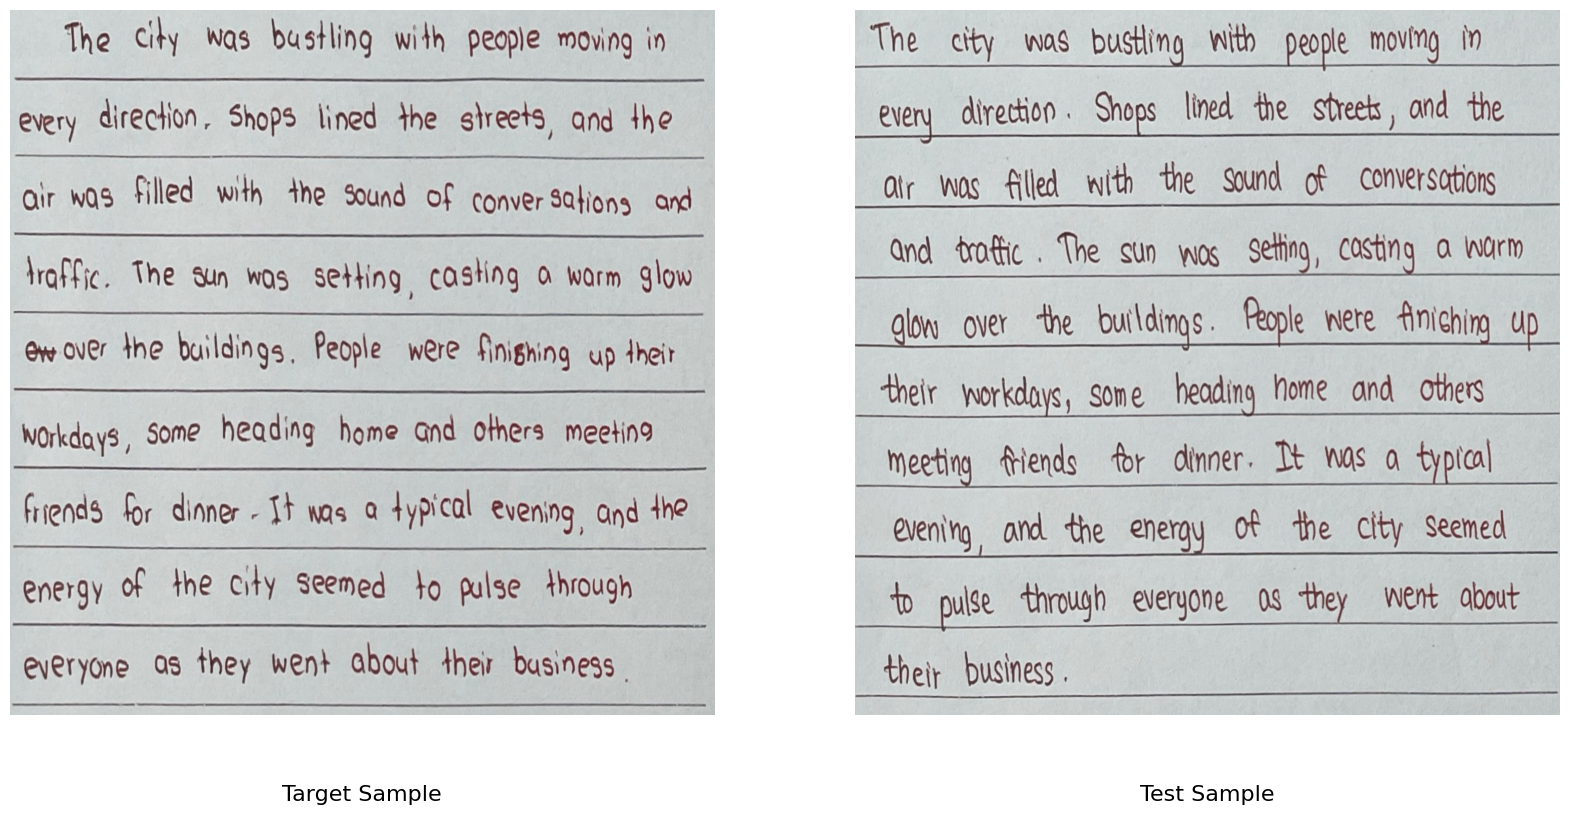

In [3]:
target_sample = cv2.resize(cv2.imread(f"{target_writer}_S01_N.png"), (1600, 1600))
test_sample = cv2.resize(cv2.imread(f"{test_writer}_S01_N.png"), (1600, 1600))
# plt.rcParams['text.usetex'] = True
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(target_sample)
plt.axis("off")
plt.text(0.5, -0.1, "Target Sample", fontsize=16, ha='center', va='top', transform=plt.gca().transAxes)
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(test_sample)
plt.text(0.5, -0.1, "Test Sample", fontsize=16, ha='center', va='top', transform=plt.gca().transAxes)

plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow(target_sample)
# plt.axis("off")
# plt.show()

# plt.figure(figsize=(20, 10))
# plt.imshow(test_sample)
# plt.axis("off")
# plt.show()


In [4]:
print(c.FEATURES)

data/uni/features_prep_mean_int_area_v3


In [5]:
scaler = load_scaler(f'{c.MODEL_FOLDER}/{c.AUTOENCODERS}/{c.TRAIN}/{target_writer}_scaler')

test_features = load_parquet(f'{c.FEATURES}/{c.TRAIN}/{test_writer}')
records_to_explain = test_features[test_features['sample'].str.contains(r'_S02_N', regex=True)]
records_to_explain = records_to_explain.drop(columns=['sample'])
records_to_explain = scaler.transform(records_to_explain)
test_features = test_features.drop(columns=['sample'])
columns = desc_columns
test_features = scaler.transform(test_features)

normal_features = load_parquet(f'{c.FEATURES}/{c.TRAIN}/{target_writer}')
normal_sample = normal_features[normal_features['sample'].str.contains(r'_S02_N', regex=True)]
normal_sample = normal_sample.drop(columns=['sample'])
normal_sample = scaler.transform(normal_sample)
normal_features = normal_features.drop(columns=['sample'])
normal_features = scaler.transform(normal_features)

model = build_global_autoencoder(normal_features.shape[1])
model.load_weights(f'{c.MODEL_FOLDER}/{c.AUTOENCODERS}/{c.TRAIN}/{target_writer}_autoencoder.weights.h5')

print(test_features.shape)

(28, 59)


/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


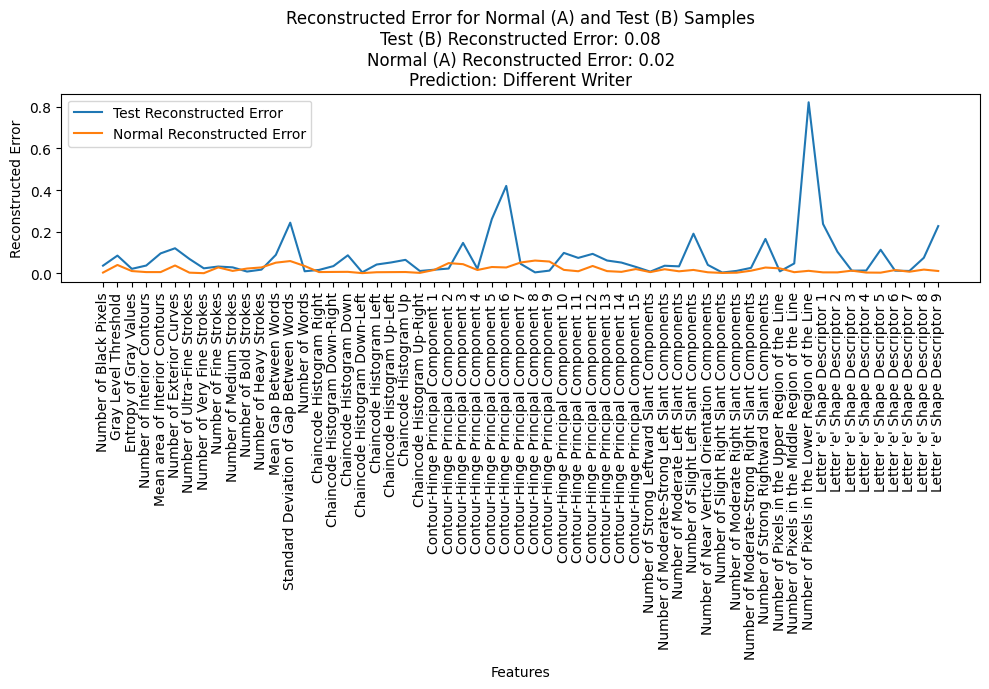

In [6]:
def predict_feature(x, idx, model):
    recon = model.predict(x, verbose=0)
    return np.square(x[:, idx] - recon[:, idx])

def build_feature_error_model(autoencoder, idx: int):
    x_in   = autoencoder.input
    x_hat  = autoencoder.output
    in_i = tf.keras.layers.Lambda(lambda x: x[:, idx:idx+1], output_shape=(1,))(x_in)
    hat_i = tf.keras.layers.Lambda(lambda x: x[:, idx:idx+1], output_shape=(1,))(x_hat)
    diff = tf.keras.layers.Subtract()([in_i, hat_i])
    sq_err = tf.keras.layers.Lambda(lambda x: tf.square(x), output_shape=(1,))(diff)
    return tf.keras.Model(inputs=x_in, outputs=sq_err)

def predict(x, model):
    return np.square(x - model.predict(x, verbose=0))

test_reconstructed = np.mean(predict(records_to_explain, model), axis=0)
normal_reconstructed = np.mean(predict(normal_sample, model), axis=0)

plt.figure(figsize=(10, 7))
plt.plot(test_reconstructed, label="Test Reconstructed Error")
plt.plot(normal_reconstructed, label="Normal Reconstructed Error")
plt.xlabel("Features")
plt.ylabel("Reconstructed Error")
plt.xticks(ticks=range(len(columns)), labels=columns, rotation=90)
plt.title(f"Reconstructed Error for Normal (A) and Test (B) Samples\nTest (B) Reconstructed Error: {np.mean(test_reconstructed):.2f}\nNormal (A) Reconstructed Error: {np.mean(normal_reconstructed):.2f}\nPrediction: {'Different Writer' if np.mean(test_reconstructed) > threshold else 'Same Writer'}")
plt.tight_layout()
plt.legend()

In [7]:
pos_shap_values = pd.DataFrame(columns=columns, index=columns, data=np.zeros((len(columns), len(columns))), dtype=float)
neg_shap_values = pd.DataFrame(columns=columns, index=columns, data=np.zeros((len(columns), len(columns))), dtype=float)
background_set = normal_features
for i in tqdm(range(len(columns)), desc="Computing SHAP values"):
    fe_model  = build_feature_error_model(model, i)
    explainer = shap.DeepExplainer(fe_model, background_set)
    shap_val = explainer.shap_values(records_to_explain)
    shap_arr = np.squeeze(shap_val, axis=2)
    pos_shap = np.where(shap_arr > 0, shap_arr, 0)
    neg_shap = np.where(shap_arr < 0, shap_arr, 0)
    pos_shap_values.iloc[i] = pos_shap.mean(axis=0)
    neg_shap_values.iloc[i] = neg_shap.mean(axis=0)

Computing SHAP values:   0%|          | 0/59 [00:00<?, ?it/s]/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(27, 59))']
  warnings.warn(msg)
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(54, 59))']
  warnings.warn(msg)
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the

In [8]:
# shap_values_all_features = pd.read_csv('shap.csv', index_col=0)
pos_sum = pos_shap_values.sum(axis=1)
neg_sum = neg_shap_values.sum(axis=1)

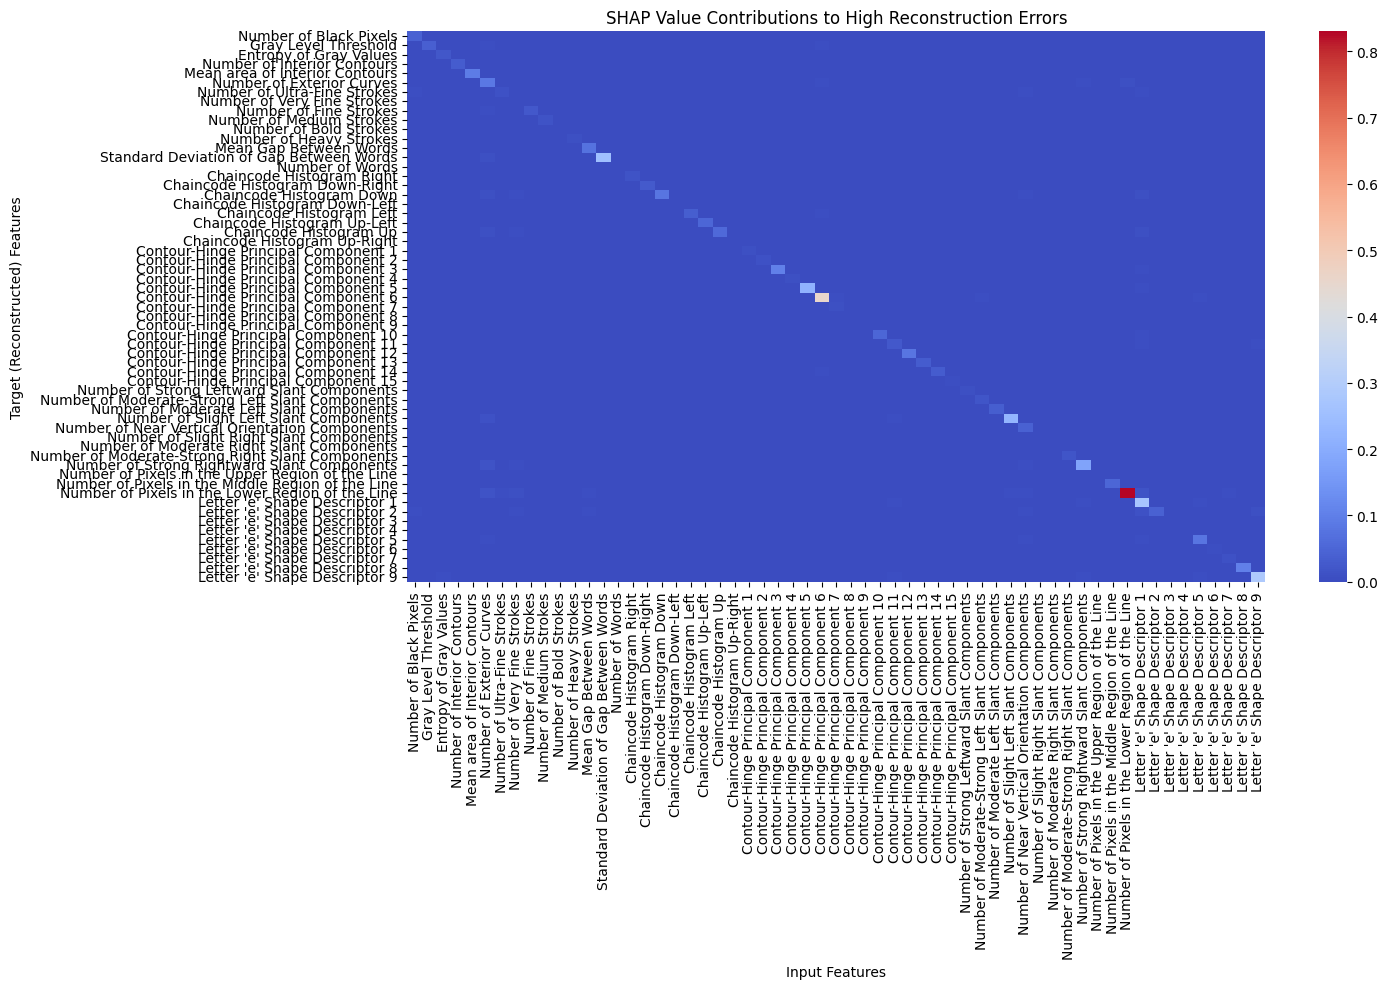

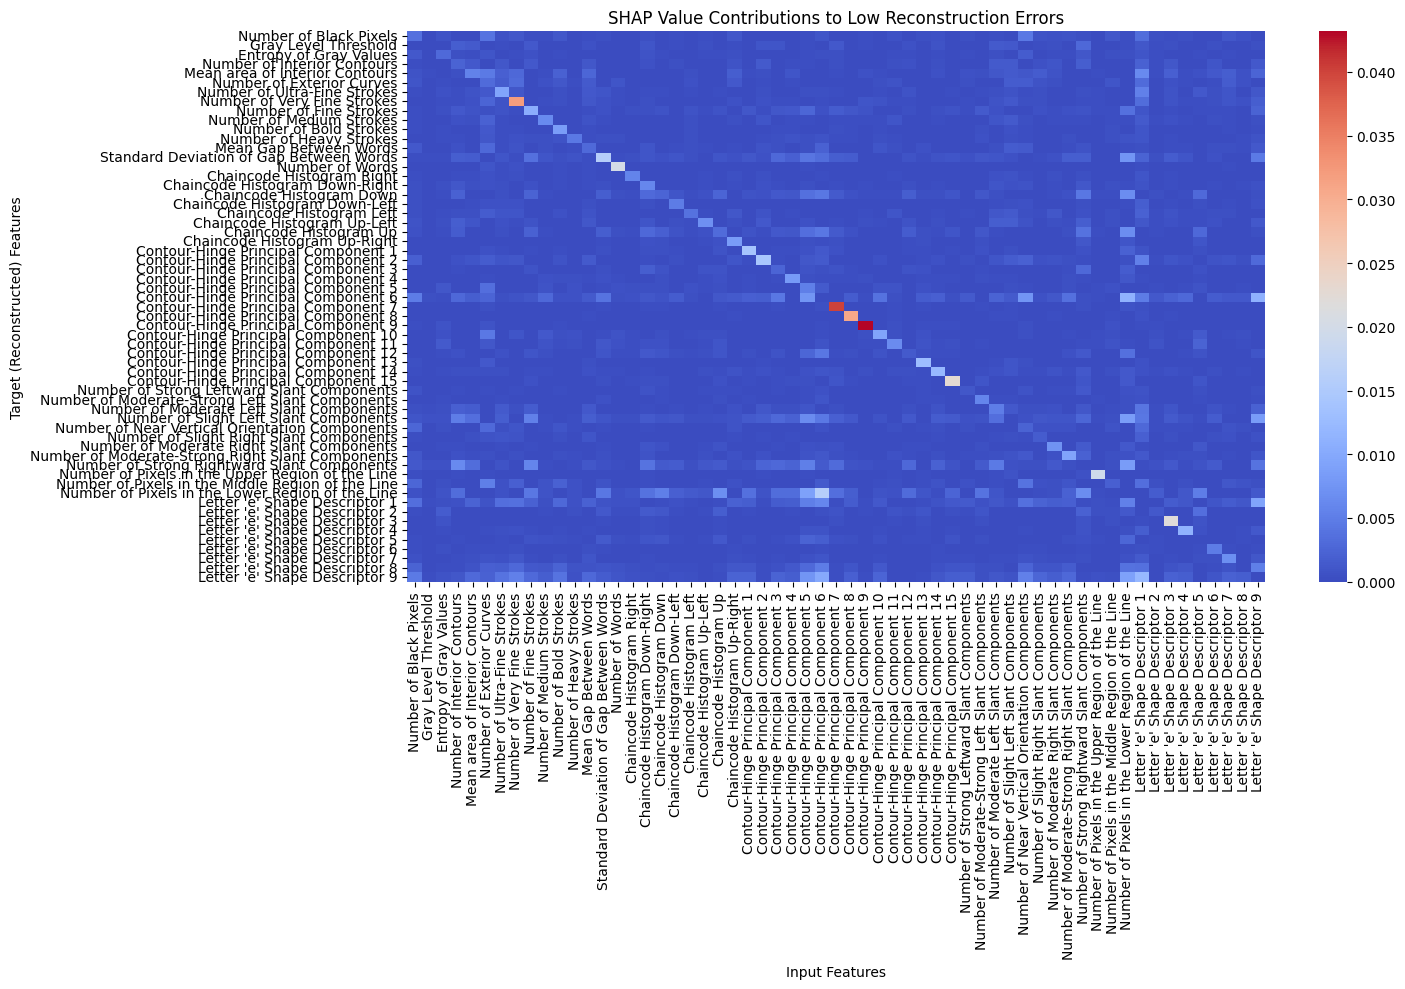

In [9]:
plt.figure(figsize=(15, 10))
sns.heatmap(pos_shap_values, cmap="coolwarm", fmt=".2f")
plt.title("SHAP Value Contributions to High Reconstruction Errors")
plt.xlabel("Input Features")
plt.ylabel("Target (Reconstructed) Features")
plt.xticks(
    ticks=np.arange(len(columns)) + 0.5,
    labels=columns,
    rotation=90,
    ha='center'
)

plt.yticks(
    ticks=np.arange(len(columns)) + 0.5,
    labels=columns,
    rotation=0,
    va='center'
)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
sns.heatmap(np.abs(neg_shap_values), cmap="coolwarm", fmt=".2f")
plt.title("SHAP Value Contributions to Low Reconstruction Errors")
plt.xlabel("Input Features")
plt.ylabel("Target (Reconstructed) Features")
plt.xticks(
    ticks=np.arange(len(columns)) + 0.5,
    labels=columns,
    rotation=90,
    ha='center'
)

plt.yticks(
    ticks=np.arange(len(columns)) + 0.5,
    labels=columns,
    rotation=0,
    va='center'
)
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.issubdtype(type(features[order[i]]), np.number):
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

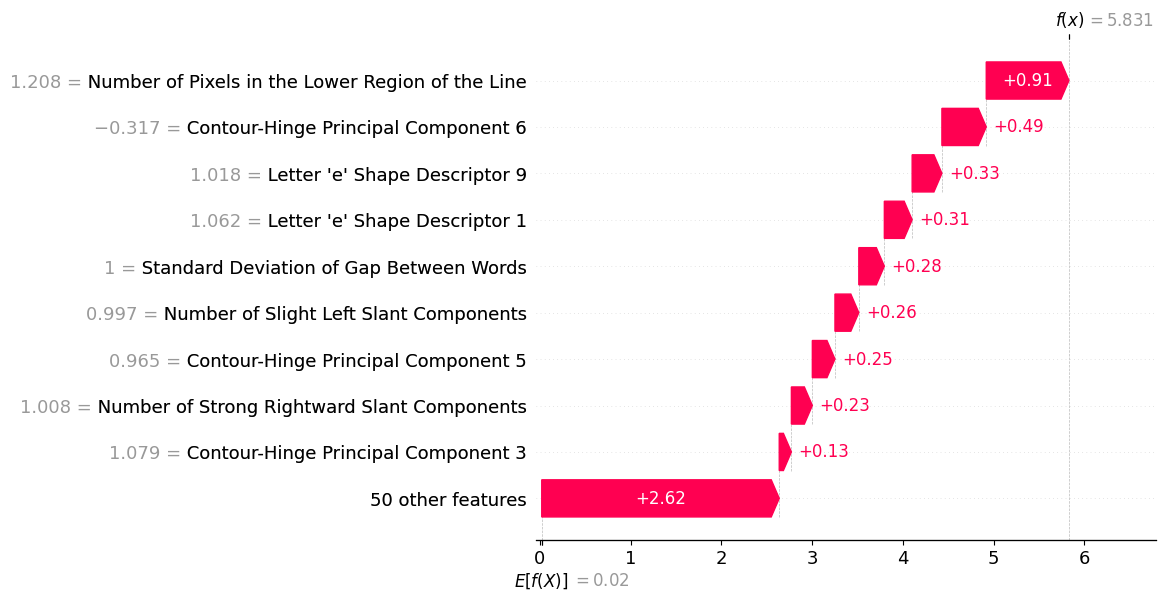

/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.issubdtype(type(features[order[i]]), np.number):
/opt/anaconda3/envs/ML/lib/python3.10/site-packages/shap/plots/_waterfall.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by posit

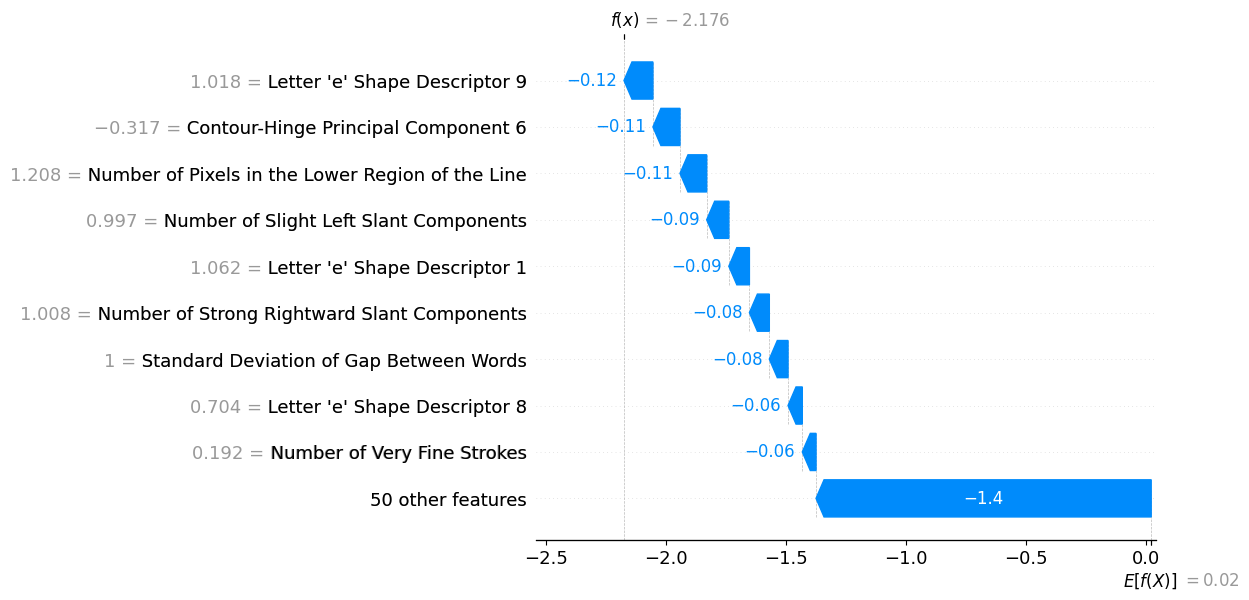

In [10]:
explanation = shap.Explanation(
    values=pos_sum,
    base_values=np.mean(predict(background_set, model)),
    data=np.mean(records_to_explain, axis=0),
    feature_names=columns
)
shap.plots.waterfall(explanation)

explanation = shap.Explanation(
    values=neg_sum,
    base_values=np.mean(predict(background_set, model)),
    data=np.mean(records_to_explain, axis=0),
    feature_names=columns
)
shap.plots.waterfall(explanation)

In [ ]:
client = OpenAI(api_key="ADD API KEY")

combined = [
    {"feature": name, "normal": n, "test": t}
    for name, n, t in zip(
        desc_columns, normal_features.mean(axis=0), test_features.mean(axis=0)
    )
]

def reconstruction_confidence(error, threshold, sharpness=15):
    sigmoid = lambda x: 1 / (1 + math.exp(-sharpness * abs(x)))
    confidence = sigmoid(error - threshold)
    return confidence

top_5_pos = pos_sum.sort_values(ascending=False).head(5)
top_5_neg = neg_sum.sort_values(ascending=True).head(5)

json_data = {
    "same_writer": bool(np.mean(test_reconstructed) < threshold),
    "features": combined,
    "test_reconstructed": np.mean(test_reconstructed).item(),
    "normal_reconstructed": np.mean(normal_reconstructed).item(),
    "threshold": threshold,
    "confidence": reconstruction_confidence(np.mean(test_reconstructed), threshold),
    "top_5_pos_sum": dict(top_5_pos),
    "top_5_neg_sum": dict(top_5_neg),
    "task_id": "test",
}

with open("prompts/sys_intructions.txt", "r") as f:
    system_instructions = f.read()
with open("prompts/chat.txt", "r") as f:
    prompt = f.read()
with open("prompts/diff_input.json", "r") as f:
    diff_input = json.load(f)
with open("prompts/same_input.json", "r") as f:
    same_input = json.load(f)
with open("prompts/diff_exp.txt", "r") as f:
    diff_exp = f.read()
with open("prompts/same_exp.txt", "r") as f:
    same_exp = f.read()

messages = [
    {"role": "system", "content": system_instructions},
    {
        "role": "user",
        "content": prompt.format(json=json.dumps(diff_input, indent=2)),
    },
    {"role": "assistant", "content": diff_exp},
    {
        "role": "user",
        "content": prompt.format(json=json.dumps(same_input, indent=2)),
    },
    {"role": "assistant", "content": same_exp},
    {
        "role": "user",
        "content": prompt.format(json=json.dumps(json_data, indent=2)),
    },
]

explanation = client.responses.create(
    model="o3",
    reasoning={"effort": "medium"},
    input=messages,
)

display(Markdown(explanation.output_text))

**Decision Overview**

The personalised auto-encoder places the test page on the “different writer” side, albeit with only medium conviction (≈50 % confidence). In other words, the model sees enough stylistic departures from the known writer’s profile to raise doubt about authorship, even though the evidence is not overwhelming.

**Largest positive SHAP contributions (pulled decision toward “different writer”)**

The table lists the five features whose positive SHAP values most strongly encouraged the model to reject the known writer hypothesis.

| Feature | Normal Value | Test Value | What to look for |
|---------|--------------|------------|------------------|
| Number of Pixels in the Lower Region of the Line | 0.36 | 1.12 | Many extra pixels below the baseline; inspect longer descenders, hanging strokes, or ink that bleeds downward. |
| Contour-Hinge Principal Component 6 | 0.45 | -0.03 | They explain shape and curvature of letters by analyzing the angles between curve segments. Look for differences in curvature and angles between segments in the handwriting. |
| Letter 'e' Shape Descriptor 9 | 0.45 | 1.00 | They capture the shape of the letter 'e' in the handwriting. Look for differences in the shape and curvature of the letter 'e' between the two samples. |
| Letter 'e' Shape Descriptor 1 | 0.52 | 1.03 | They capture the shape of the letter 'e' in the handwriting. Look for differences in the shape and curvature of the letter 'e' between the two samples. |
| Standard Deviation of Gap Between Words | 0.59 | 0.93 | Wider spread of word spacing; examine whether gaps fluctuate more than usual across the line. |

**How these features interact**

Together, the added lower-line ink and altered letter curvature suggest the pen is travelling lower and bending differently, while the changed shapes of several ‘e’s underline a fresh hand movement. The larger variability in word spacing reinforces the impression of a different writing rhythm. These distinct yet complementary signals combined to nudge the model toward a “different writer” verdict.

**Strongest negative SHAP contributions (pushed back toward “known writer”)**

If you remain uncertain, review the features below—the only elements that partly counter-balanced the evidence above.

| Feature | Normal Value | Test Value | What to look for |
|---------|--------------|------------|------------------|
| Number of Slight Left Slant Components | 0.50 | 1.04 | Similar mix of gently left-leaning strokes; compare overall slant consistency across letters. |

**Final note**

Overall the statistical picture leans away from the known writer, yet the confidence is modest and some slant patterns still line up. Please study the highlighted areas—descenders, ‘e’ formations, spacing, curvature, and stroke slant—in the original images before drawing a firm conclusion. Automated findings are best confirmed by a careful visual review.